## Single cell data analysis using Scanpy

This analysis is done following the `Clustering 3K PBMCs` tutorial from [Scanpy documentation](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)

In [1]:
%%bash
rm -rf cache
rm -rf /tmp/data
mkdir -p /tmp/data
wget -q -O /tmp/data/pbmc3k_filtered_gene_bc_matrices.tar.gz \
  /tmp/data http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
cd /tmp/data
tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 0

In [4]:
sc.logging.print_versions()

scanpy==1.4 anndata==0.6.22.post1 numpy==1.15.4 scipy==1.1.0 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [5]:
results_file = '/tmp/pbmc3k.h5ad'

In [6]:
sc.settings.set_figure_params(dpi=80)

In [7]:
adata = \
  sc.read_10x_mtx(
    '/tmp/data/filtered_gene_bc_matrices/hg19/',
    var_names='gene_symbols',
    cache=True)

In [8]:
adata.var_names_make_unique()

In [9]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738 
    var: 'gene_ids'

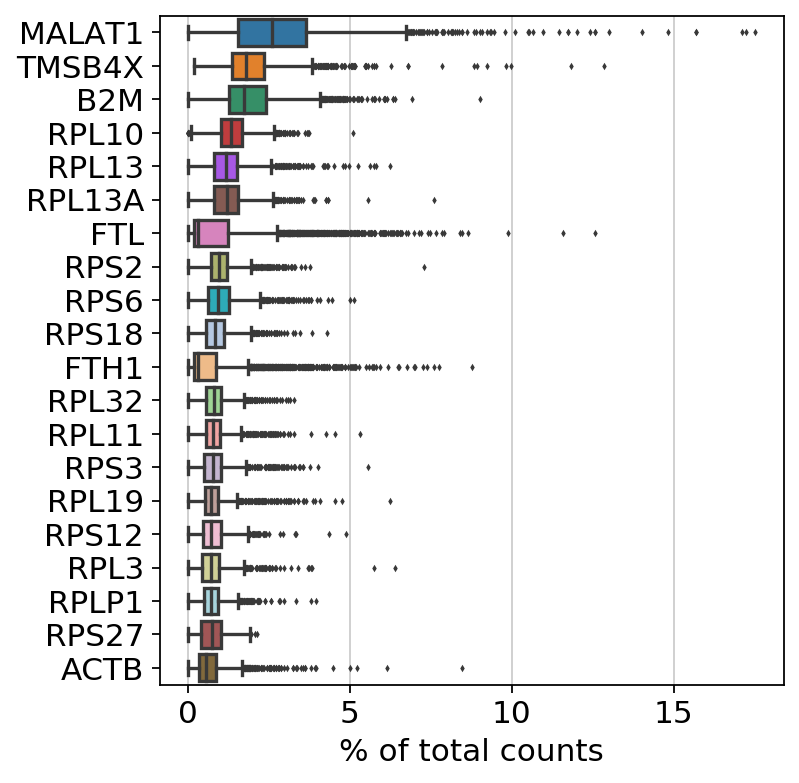

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [11]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [12]:
mito_genes = adata.var_names.str.startswith('MT-')

In [13]:
adata.obs['percent_mito'] = \
  np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

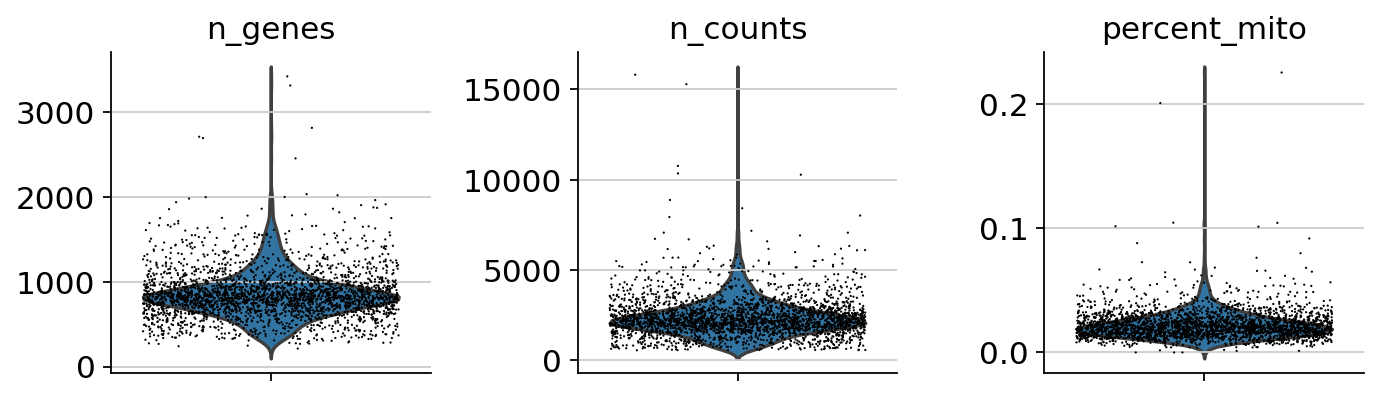

In [14]:
sc.pl.violin(\
  adata,
  ['n_genes', 'n_counts', 'percent_mito'],
  jitter=0.4,
  multi_panel=True)

/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be remo

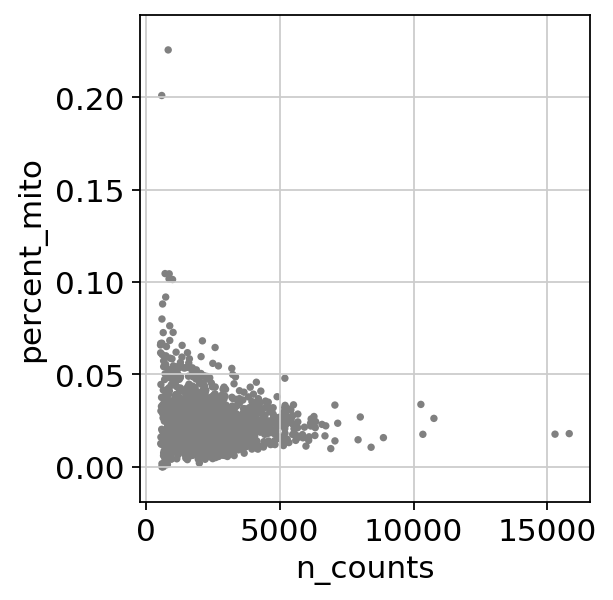

/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be remo

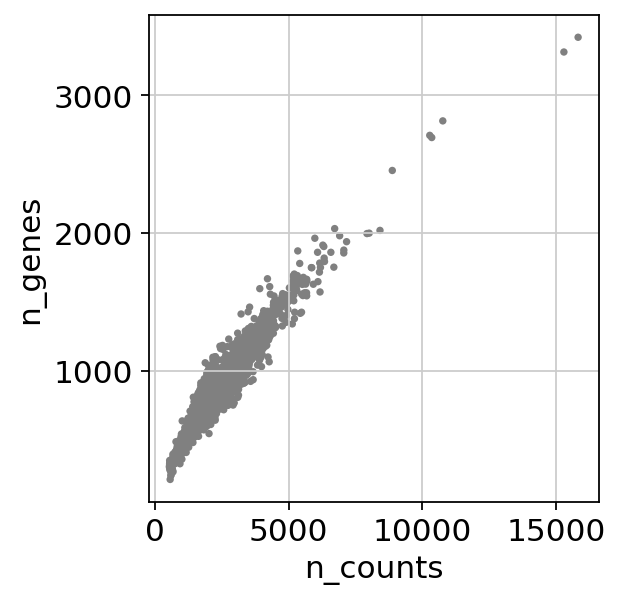

In [15]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito');
sc.pl.scatter(adata, x='n_counts', y='n_genes');

In [16]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [17]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [18]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Trying to set attribute `.obs` of view, making a copy.


In [19]:
sc.pp.log1p(adata)

In [20]:
adata.raw = adata

In [21]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

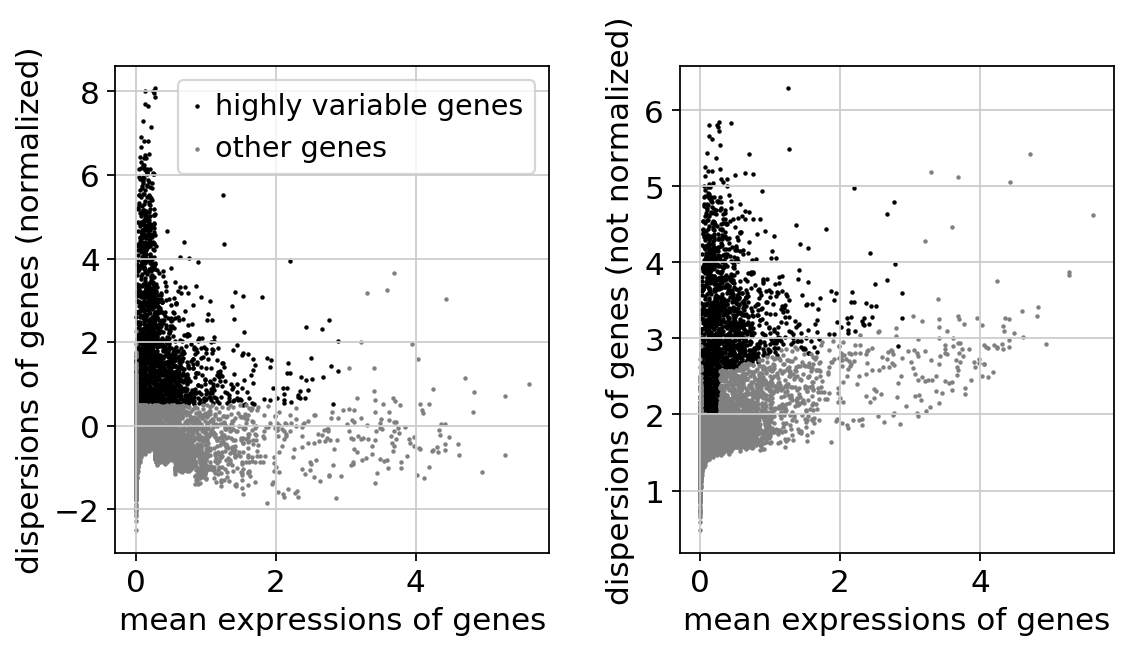

In [22]:
sc.pl.highly_variable_genes(adata)

In [23]:
adata = adata[:, adata.var['highly_variable']]

In [24]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

In [25]:
sc.pp.scale(adata, max_value=10)

In [26]:
sc.tl.pca(adata, svd_solver='arpack')

/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


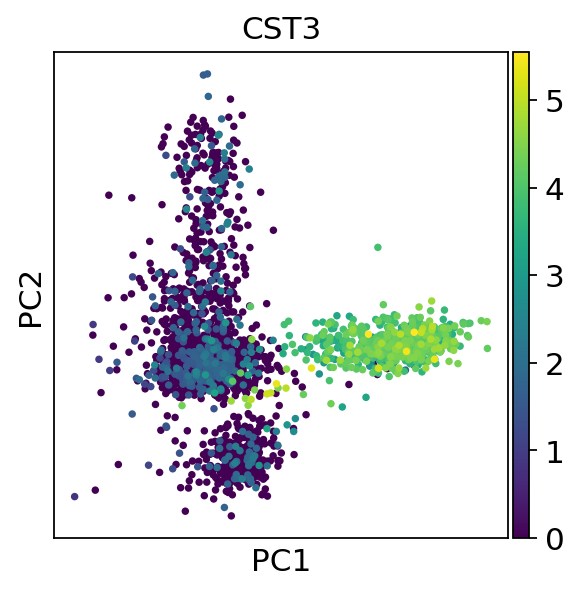

In [27]:
sc.pl.pca(adata, color='CST3');

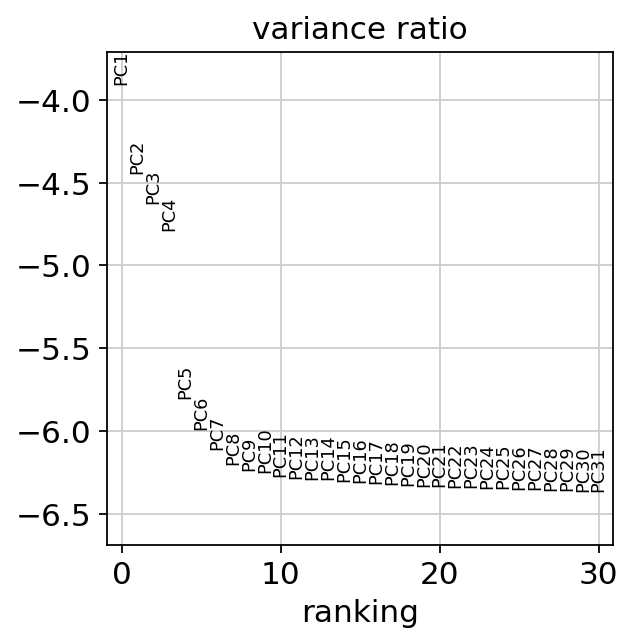

In [28]:
sc.pl.pca_variance_ratio(adata, log=True)

In [29]:
adata.write(results_file)

In [30]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [31]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [32]:
sc.tl.umap(adata)

/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


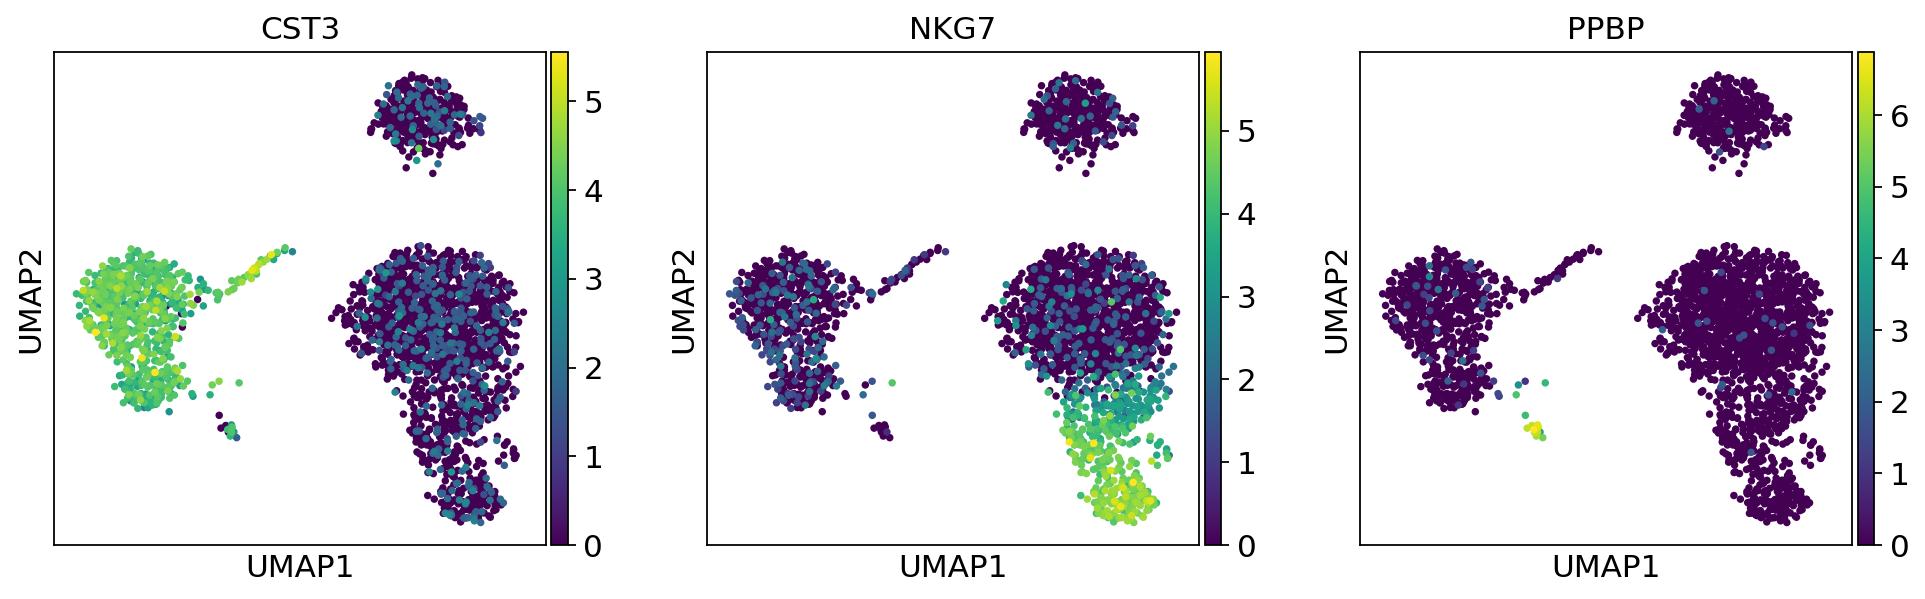

In [33]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP']);

/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


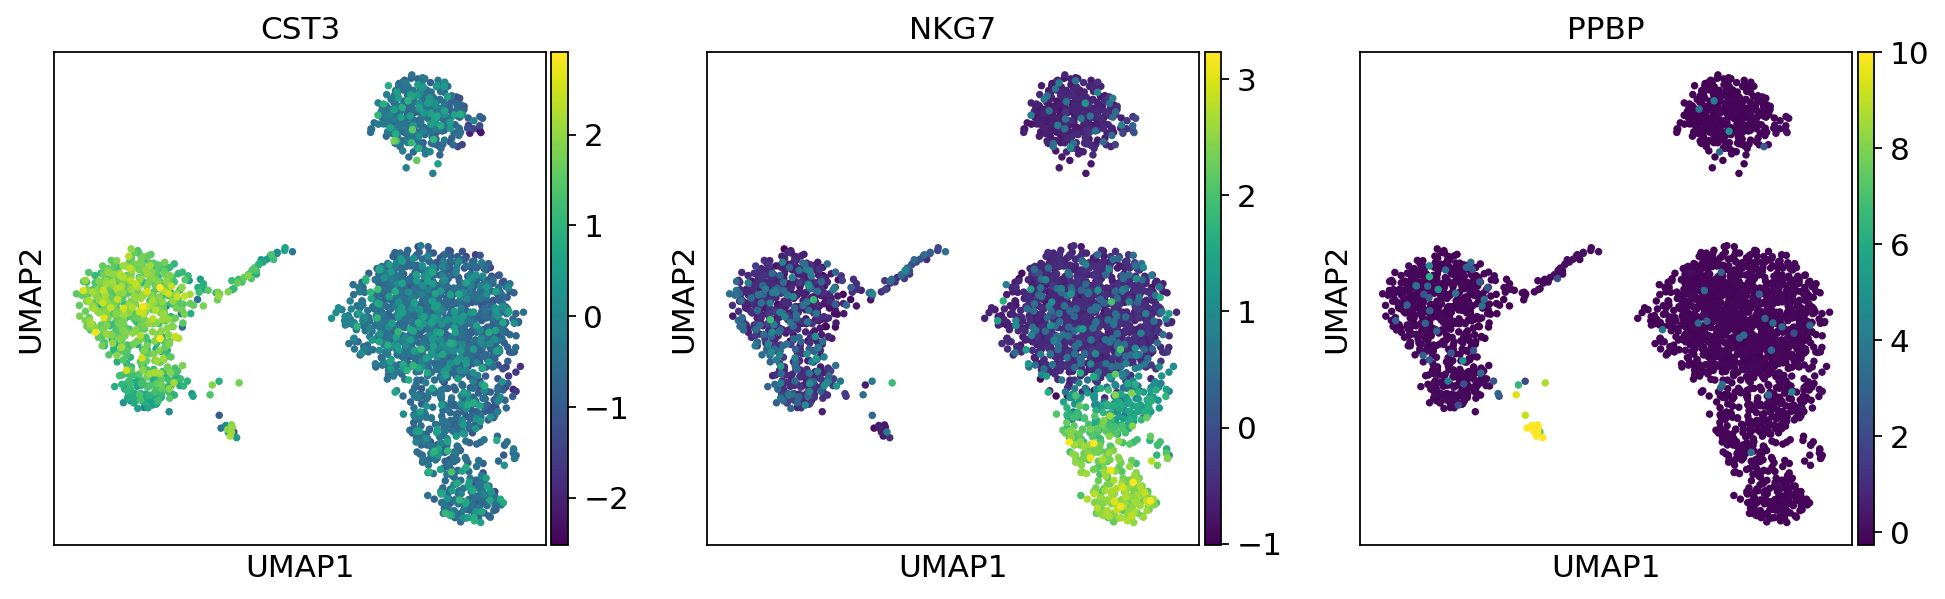

In [34]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [35]:
sc.tl.louvain(adata)

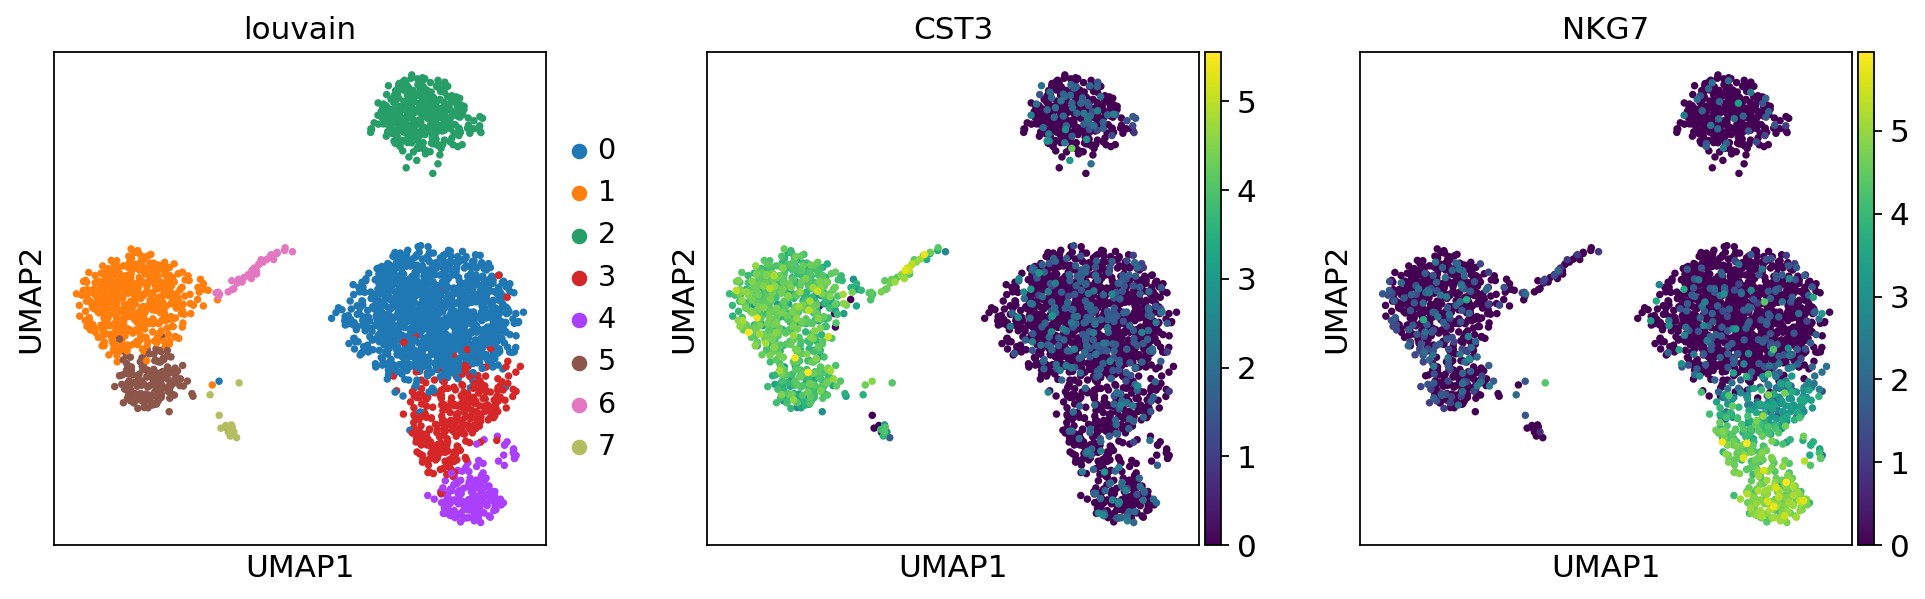

In [36]:
sc.pl.umap(adata, color=['louvain', 'CST3', 'NKG7'])

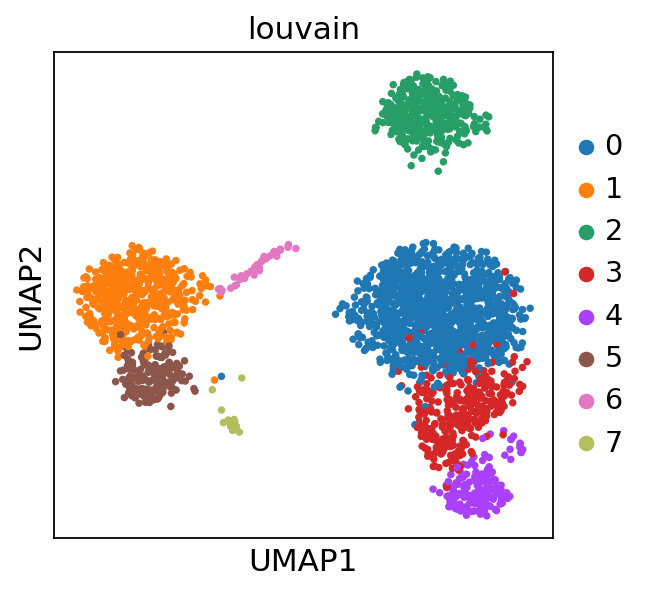

In [37]:
sc.pl.umap(adata, color=['louvain'], use_raw=False)

In [38]:
adata.write(results_file)

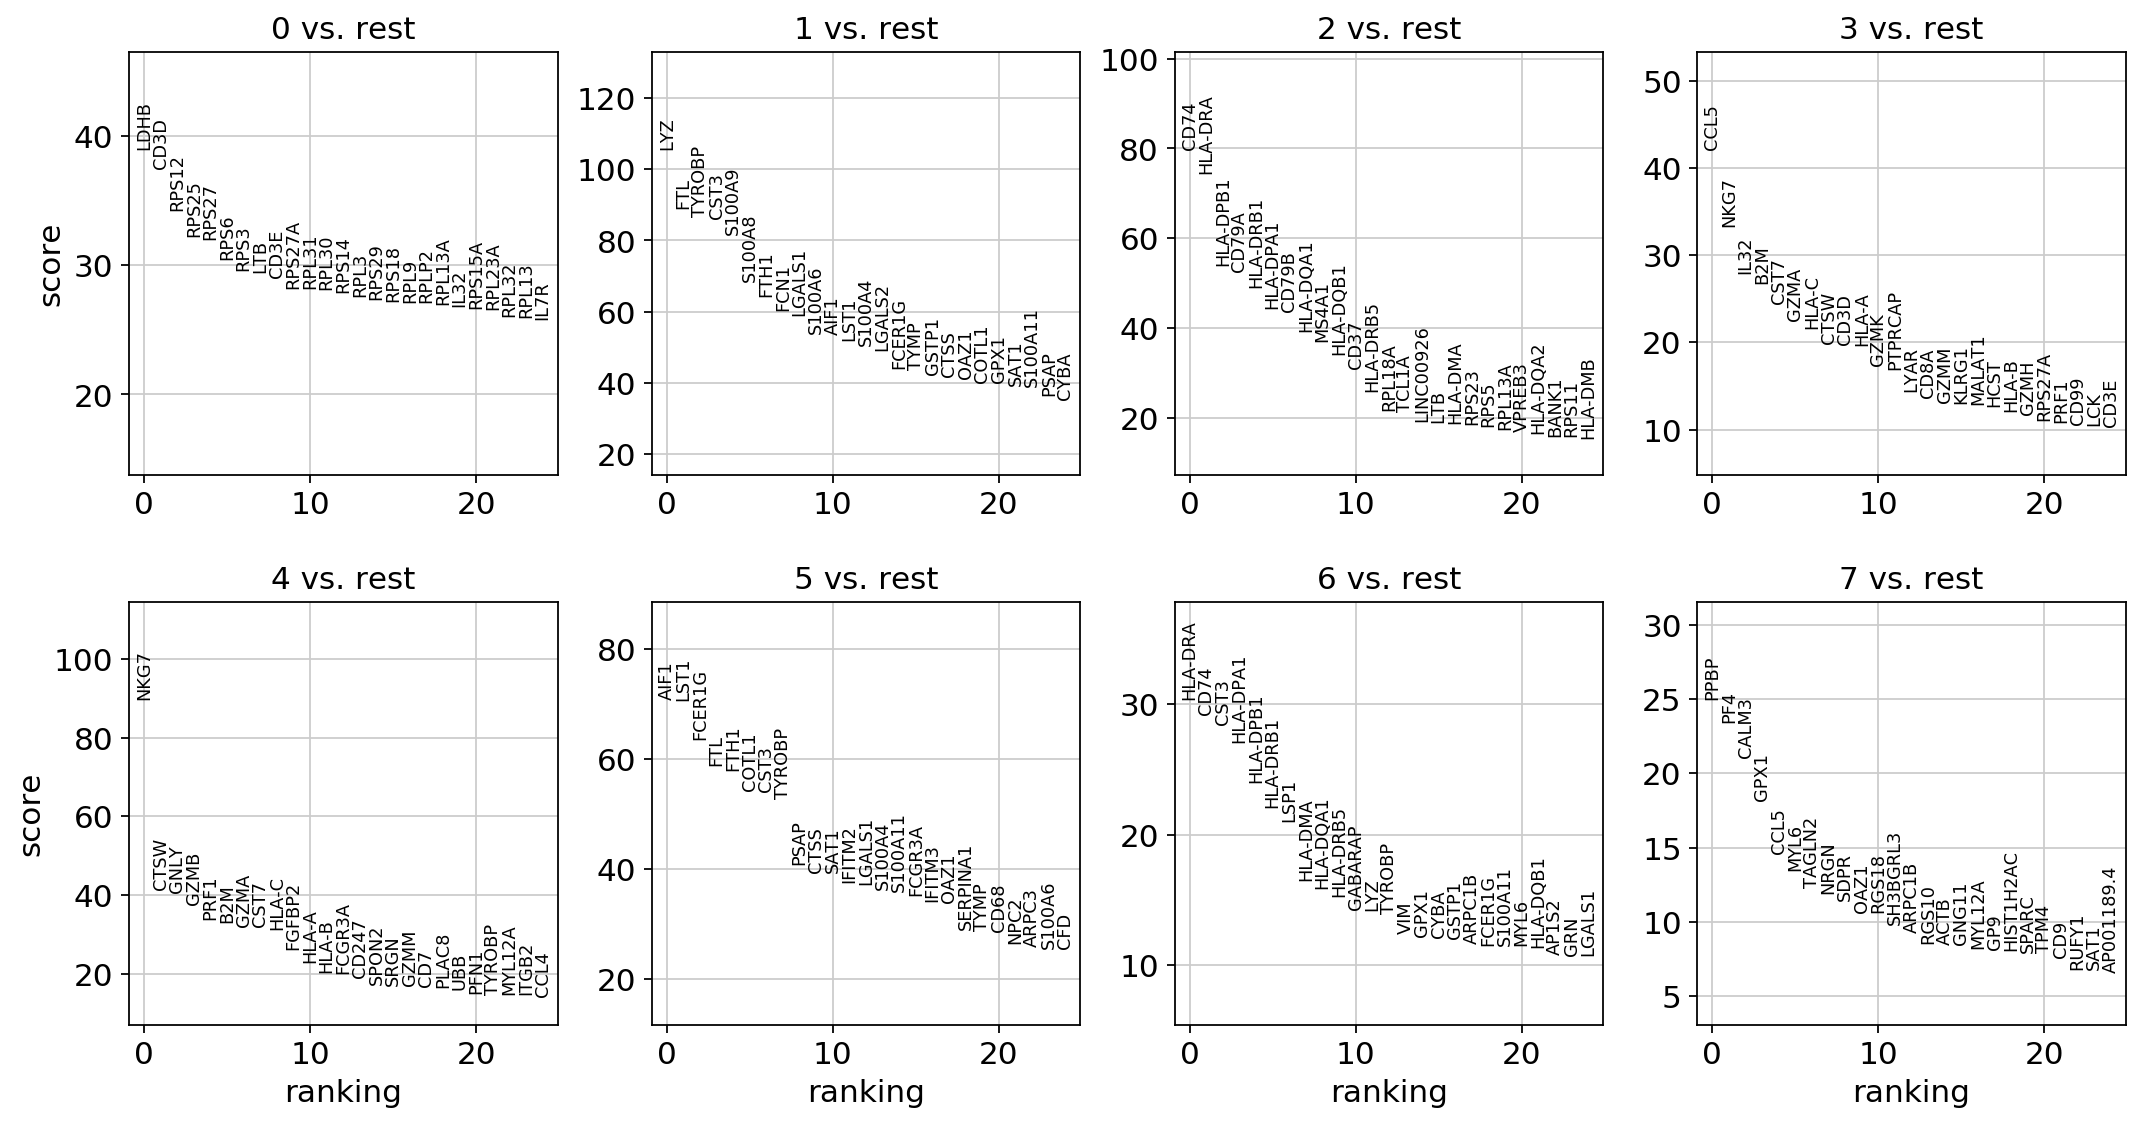

In [39]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False);

In [40]:
sc.settings.verbosity = 2

In [41]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [42]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,LDHB,LYZ,CD74,CCL5,NKG7,AIF1,HLA-DRA,PPBP
1,CD3D,FTL,HLA-DRA,NKG7,CTSW,LST1,CD74,PF4
2,RPS12,TYROBP,HLA-DPB1,IL32,GNLY,FCER1G,CST3,CALM3
3,RPS25,CST3,CD79A,B2M,GZMB,FTL,HLA-DPA1,GPX1
4,RPS27,S100A9,HLA-DRB1,CST7,PRF1,FTH1,HLA-DPB1,CCL5


In [43]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,LDHB,2.207563e-262,LYZ,0.0,CD74,0.000000e+00,CCL5,4.733837e-149,NKG7,2.593381e-233,AIF1,6.024990e-247,HLA-DRA,6.562929e-32,PPBP,5.028116e-13
1,CD3D,7.693815e-246,FTL,0.0,HLA-DRA,0.000000e+00,NKG7,3.861772e-115,CTSW,1.068165e-97,LST1,3.835773e-206,CD74,2.552707e-31,PF4,1.229132e-12
2,RPS12,3.798472e-208,TYROBP,0.0,HLA-DPB1,2.257926e-272,IL32,4.302269e-105,GNLY,3.966201e-87,FCER1G,7.490000e-193,CST3,2.602294e-29,CALM3,2.473624e-12
3,RPS25,2.489225e-189,CST3,0.0,CD79A,1.606677e-169,B2M,3.907152e-101,GZMB,8.431221e-82,FTL,4.056422e-217,HLA-DPA1,4.913713e-28,GPX1,2.596160e-11
4,RPS27,1.394692e-186,S100A9,0.0,HLA-DRB1,2.281448e-243,CST7,3.653891e-77,PRF1,6.469934e-76,FTH1,5.169743e-192,HLA-DPB1,2.866306e-25,CCL5,4.517762e-10


ranking genes
    finished (0:00:02.05)


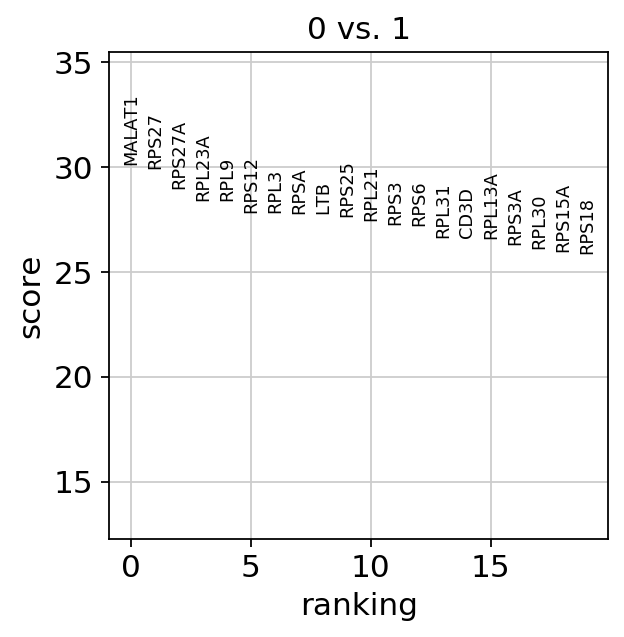

In [44]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

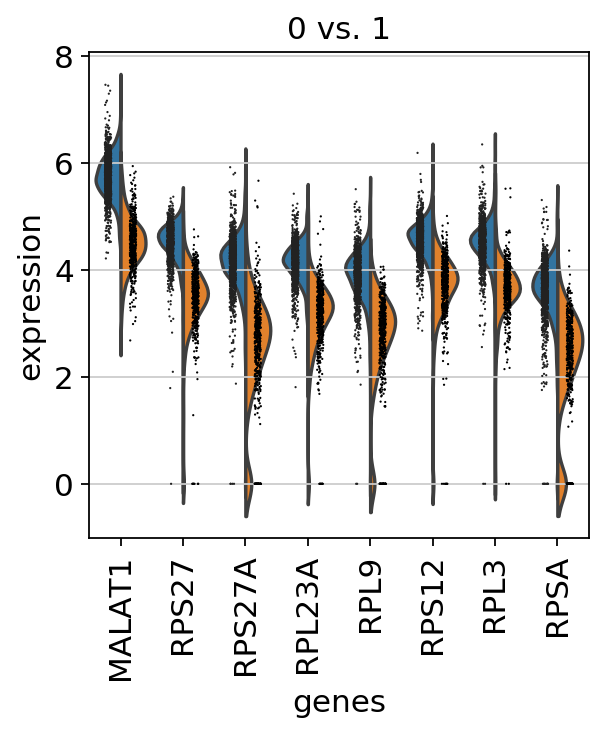

In [45]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [46]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')

ranking genes
    finished (0:00:04.41)


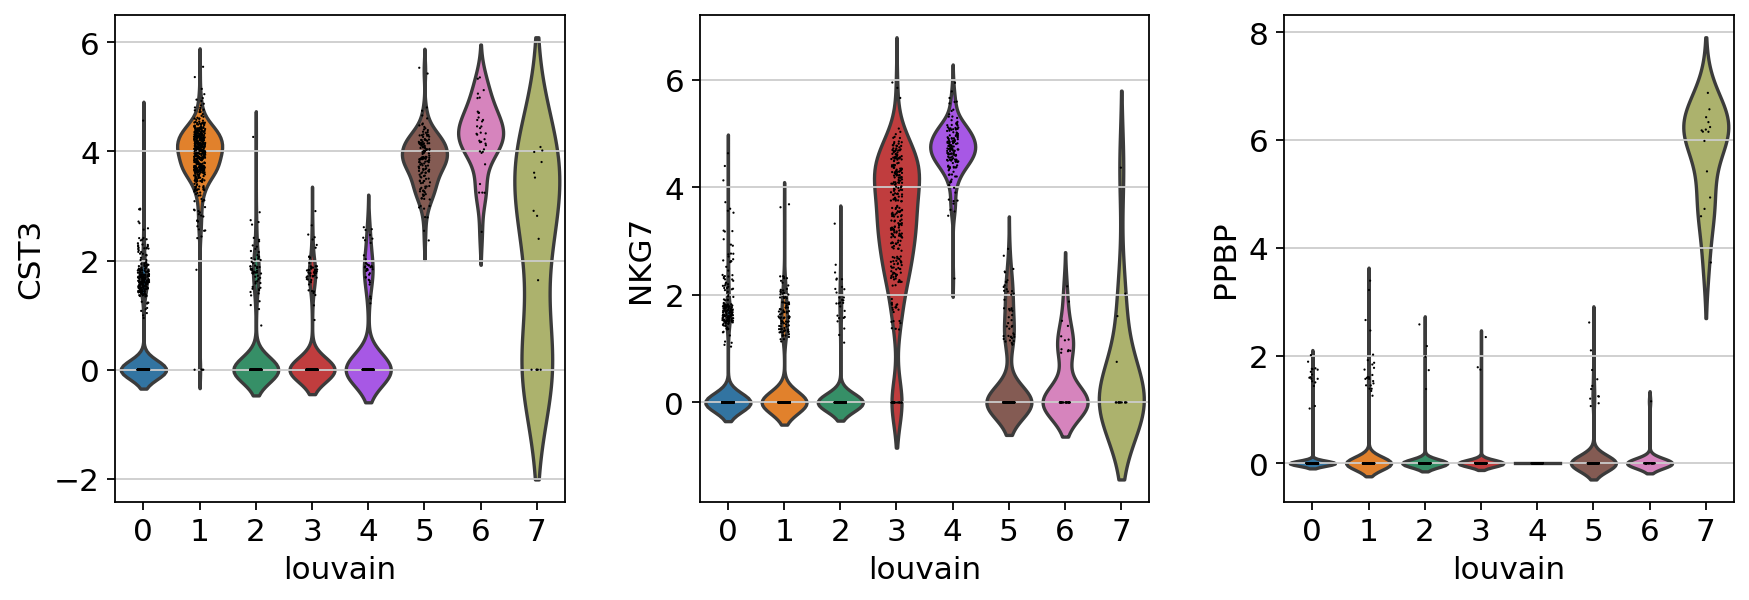

In [47]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')

In [48]:
new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A+ Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)

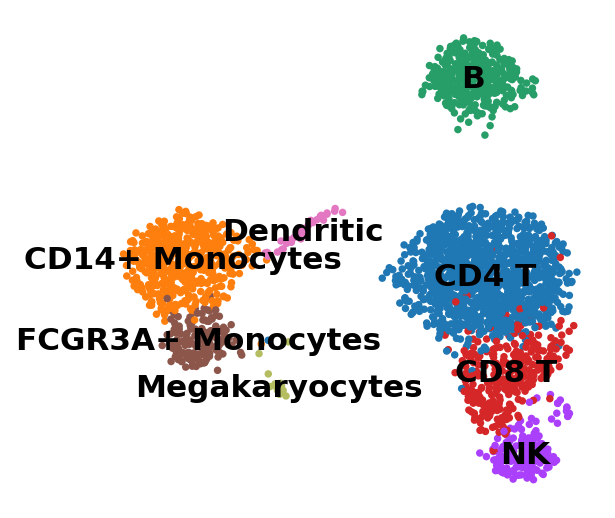

In [49]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False)

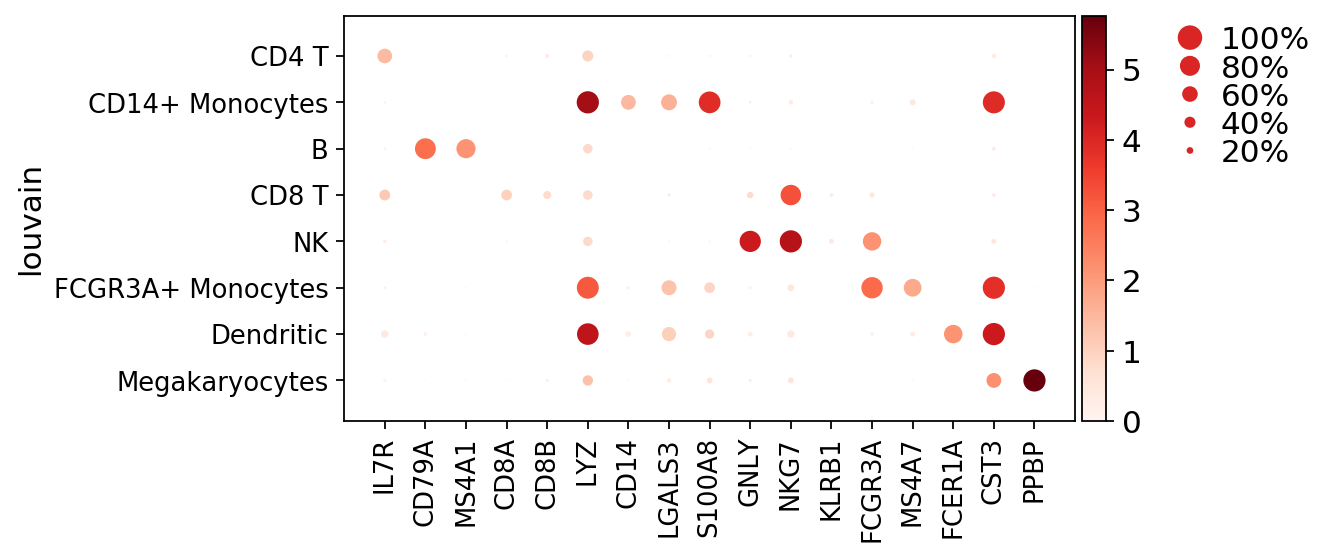

In [50]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain')

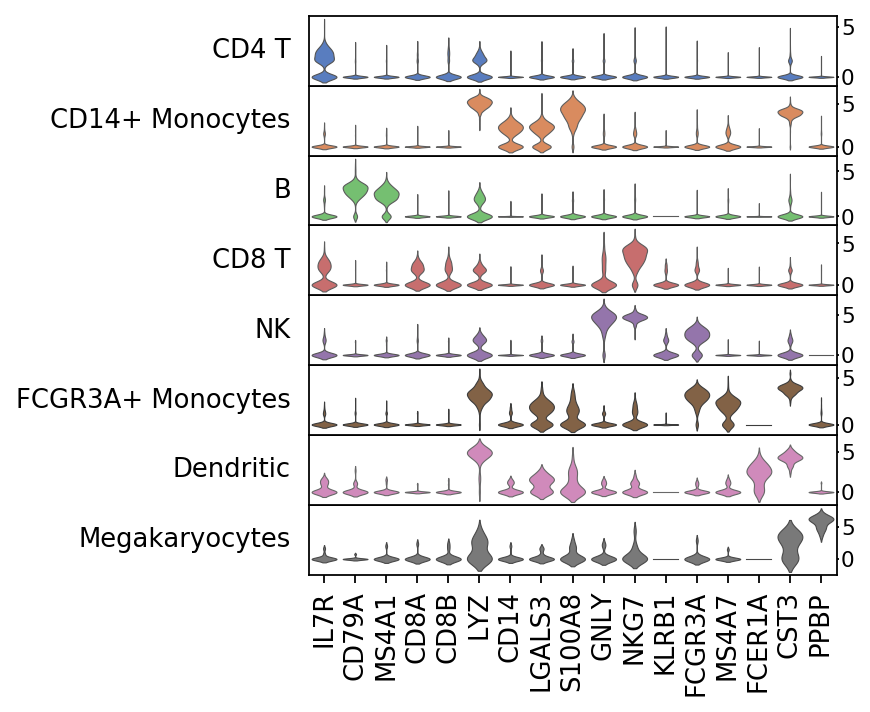

In [51]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)

In [52]:
adata.write(results_file)